In [58]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
%matplotlib inline

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-06-21 17:04:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.03s   

2020-06-21 17:04:24 (158 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [3]:
df = pd.read_csv("/tmp/bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,steady job growth continues in us the us creat...
freq,511,2


In [5]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [6]:
print(df.shape)

(2225, 2)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


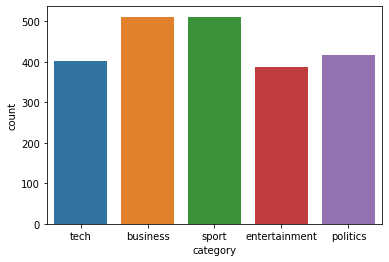

In [7]:
import seaborn as sns
sns.countplot(x='category',data=df)

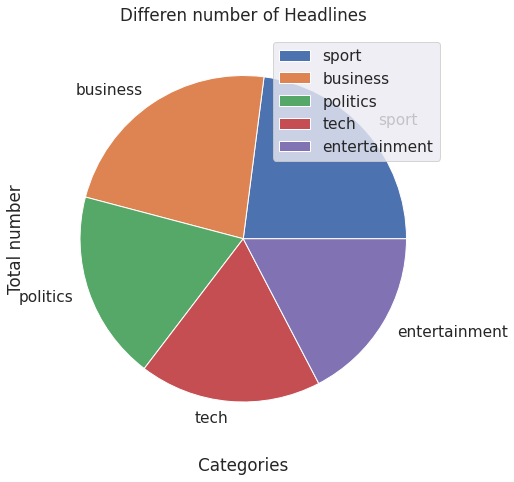

In [8]:
sns.set(font_scale=1.4)
df['category'].value_counts().plot(kind='pie', figsize=(10, 7), rot=0)
plt.xlabel("Categories", labelpad=14)
plt.ylabel("Total number", labelpad=14)
plt.title("Differen number of Headlines", y=1.02)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [10]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [13]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(f'Total number of sentences are {len(sentences)}')
print(f'Total number of labels are {len(labels)}')
print(sentences[0])

Total number of sentences are 2225
Total number of labels are 2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding networ

In [14]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print("Training size is {}".format(train_size))
print("Length of sentences in training set is {}".format(len(train_sentences)))
print("Length of labels in training set is {}".format(len(train_labels)))
print("Length of sentences in validation set is {}".format(len(validation_sentences)))
print("Length of labels in validation set is {}".format(len(validation_labels)))

Training size is 1780
Length of sentences in training set is 1780
Length of labels in training set is 1780
Length of sentences in validation set is 445
Length of labels in validation set is 445


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
#tokenizing
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

In [18]:
#creating word index
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 's': 2, 'said': 3, 'will': 4, 'not': 5, 'mr': 6, 'year': 7, 'also': 8, 'people': 9, 'new': 10, 'us': 11, 'one': 12, 'can': 13, 'last': 14, 't': 15, 'first': 16, 'time': 17, 'two': 18, 'government': 19, 'world': 20, 'now': 21, 'uk': 22, 'best': 23, 'years': 24, 'no': 25, 'make': 26, 'just': 27, 'film': 28, 'told': 29, 'made': 30, 'get': 31, 'music': 32, 'game': 33, 'like': 34, 'back': 35, 'many': 36, '000': 37, 'labour': 38, 'three': 39, 'well': 40, '1': 41, 'next': 42, 'bbc': 43, 'take': 44, 'set': 45, 'number': 46, 'added': 47, 'way': 48, 'market': 49, '2': 50, 'company': 51, 'may': 52, 'says': 53, 'election': 54, 'home': 55, 'off': 56, 'party': 57, 'good': 58, 'going': 59, 'much': 60, 'work': 61, '2004': 62, 'still': 63, 'win': 64, 'show': 65, 'think': 66, 'games': 67, 'go': 68, 'top': 69, 'second': 70, 'won': 71, 'million': 72, '6': 73, 'england': 74, 'firm': 75, 'since': 76, 'week': 77, 'say': 78, 'play': 79, 'part': 80, 'public': 81, 'use': 82, 'blair': 83, '3': 84, '

In [19]:
#creating sequences for training sentences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sequences)

[[99, 170, 1, 1, 55, 993, 771, 1, 97, 1, 1, 139, 186, 1, 1, 1, 1, 48, 9, 907, 99, 4, 1, 347, 93, 24, 17, 140, 1, 1, 1, 585, 465, 1, 65, 1, 1, 1, 10, 935, 4, 745, 12, 858, 1, 11, 613, 1, 1, 408, 4, 1, 1, 746, 55, 552, 1, 1, 1, 144, 262, 123, 1, 809, 1, 994, 599, 12, 1, 1, 935, 1, 139, 357, 186, 1, 1, 1, 45, 69, 1, 34, 11, 2, 1, 22, 2, 1, 146, 429, 9, 153, 1, 79, 1, 449, 1, 99, 1, 85, 1, 90, 1, 60, 1, 99, 8, 1, 614, 97, 1, 99, 1, 141, 147, 433, 11, 1, 44, 56, 162, 1, 97, 1, 1, 5, 13, 9, 449, 1, 1, 13, 8, 1, 1, 444, 1, 1, 1, 586, 1, 1, 1, 782, 11, 552, 1, 1, 144, 1, 413, 859, 1, 1, 40, 1, 1, 1, 1, 1, 257, 11, 1, 90, 747, 8, 1, 1, 162, 735, 606, 1, 134, 34, 1, 1, 445, 4, 91, 947, 125, 24, 17, 22, 1, 1, 43, 1, 2, 1, 29, 43, 95, 348, 1, 43, 25, 481, 268, 1, 1, 341, 1, 312, 747, 1, 22, 1, 1, 1, 307, 772, 4, 1, 408, 1, 400, 444, 1, 3, 1, 1, 1, 1, 75, 1, 1, 1, 262, 1, 1, 13, 1, 408, 47, 892, 21, 259, 1, 358, 60, 562, 413, 3, 1, 1, 670, 1, 214, 99, 1, 99, 98, 48, 9, 333, 408, 85, 907, 1, 99, 1, 

In [20]:
print(train_sentences[0])

tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us 

In [21]:
print(word_index["tv"])
#if my outcome is 99 then it's fine

99


In [22]:
print("Sequence length of first sentence in training set is",len(train_sequences[0]))
print("Sequence length of second sentence in training set is",len(train_sequences[1]))
#there is a difference between length of all these sentence sequences
# so i'll be using post padding and maxlen function to make their length same i.e 120

Sequence length of first sentence in training set is 449
Sequence length of second sentence in training set is 200


In [24]:
# now i'm creating padding sequences
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
print(train_padded)
print("***********")
print("Length of padded sentence in training set is",len(train_padded[0]))

[[454 466   3 ... 907  85  85]
 [  1   6   1 ...   1   1   1]
 [925   1   1 ...   1  30   1]
 ...
 [669   1 448 ... 248   1 845]
 [  1   1 293 ...   1   1  96]
 [  1   1 975 ...   1   1 343]]
***********
Length of padded sentence in training set is 120


In [25]:
print("length of first sentence was ",len(train_sequences[0]))
print("length of first sentence after padding is ", len(train_padded[0]))

print("length of second sentence was ",len(train_sequences[1]))
print("length of second sentence after padding is ", len(train_padded[1]))

length of first sentence was  449
length of first sentence after padding is  120
length of second sentence was  200
length of second sentence after padding is  120


In [26]:
# now doing the same for validation set
# creating sequence
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
print("Length of first sentence sequence is",len(validation_sequences[0]))
print(validation_sequences[0])

Length of first sentence sequence is 160
[1, 1, 112, 24, 226, 276, 1, 132, 1, 1, 3, 4, 112, 24, 1, 61, 28, 493, 1, 674, 903, 3, 1, 1, 1, 26, 5, 1, 1, 66, 2, 1, 219, 1, 1, 1, 498, 1, 136, 4, 364, 1, 3, 10, 1, 317, 1, 1, 2, 528, 1, 18, 328, 28, 1, 1, 326, 1, 1, 891, 1, 1, 1, 3, 301, 353, 1, 1, 508, 1, 1, 1, 569, 1, 7, 109, 642, 558, 1, 276, 1, 1, 1, 1, 37, 1, 76, 1, 289, 28, 1, 505, 1, 28, 51, 10, 222, 1, 1, 1, 1, 1, 628, 268, 1, 16, 80, 1, 1, 1, 1, 1, 499, 311, 26, 1, 628, 1, 72, 1, 72, 1, 301, 1, 1, 28, 1, 136, 776, 1, 1, 1, 326, 455, 1, 1, 681, 1, 1, 674, 903, 1, 1, 271, 422, 289, 1, 8, 1, 202, 28, 493, 1, 1, 151, 23, 786, 528, 1, 1]


In [27]:
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)
print(f'After padding length of sequence is {len(validation_padded[0])}')

After padding length of sequence is 120


In [28]:
# converting label text(tags) to tokens and then converting it into np.array
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [30]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 0s - loss: 1.7651 - accuracy: 0.2247 - val_loss: 1.7332 - val_accuracy: 0.2382
Epoch 2/30
56/56 - 0s - loss: 1.6907 - accuracy: 0.2376 - val_loss: 1.6471 - val_accuracy: 0.2449
Epoch 3/30
56/56 - 0s - loss: 1.5888 - accuracy: 0.3618 - val_loss: 1.5331 - val_accuracy: 0.4157
Epoch 4/30
56/56 - 0s - loss: 1.4422 - accuracy: 0.4562 - val_loss: 1.3721 - val_accuracy: 0.4921
Epoch 5/30
56/56 - 0s - loss: 1.2490 - accuracy: 0.5657 - val_loss: 1.1812 - val_accuracy: 0.6292
Epoch 6/30
56/56 - 0s - loss: 1.0451 - accuracy: 0.7500 - val_loss: 0.9990 - val_accuracy: 0.7753
Epoch 7/30
56/56 - 0s - loss: 0.8624 - accuracy: 0.8584 - val_loss: 0.8391 - val_accuracy: 0.8584
Epoch 8/30
56/56 - 0s - loss: 0.6977 - accuracy: 0.9096 - val_loss: 0.6945 - val_accuracy: 0.8809
Epoch 9/30
56/56 - 0s - loss: 0.5526 - accuracy: 0.9404 - val_loss: 0.5727 - val_accuracy: 0.8966
Epoch 10/30
56/56 - 0s - loss: 0.4395 - accuracy: 0.9478 - val_loss: 0.4834 - val_accuracy: 0.9101
Epoch 11/30
56/56 -

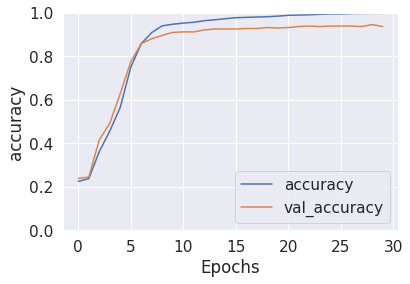

In [31]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylim(0.00,1.00)
  plt.ylabel(string)
  plt.legend([string, 'val_'+string],loc='best')
  plt.show()
  
plot_graphs(history, "accuracy")

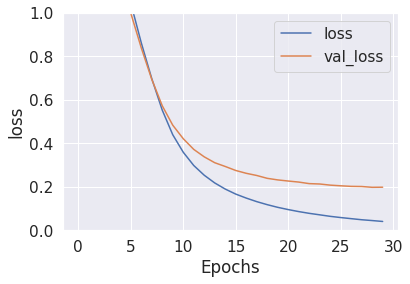

In [32]:
plot_graphs(history, "loss")

# Predictions
## Still have to figure out what's going wrong

In [45]:
label_classes = label_tokenizer.word_index
print(label_classes)

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


In [46]:
classlist = []
for key,value in label_classes.items():
  classlist.append(key)
print(classlist)

['sport', 'business', 'politics', 'tech', 'entertainment']


In [56]:
print("Actual sentences vs labels:")
for j in range(15,25):
  print(f'{validation_labels[j]} : {validation_sentences[j]}')

Actual sentences vs labels:
entertainment : us tv cuts nudity bbc film us tv network editing bbc films  dirty war avoid showing front nude woman scrubbed fictional chemical attack.  not worth showing  non-essential  nude scenes indecency complaints  aggressively pursued  us tv watchdogs  said pbs  jacoba atlas. dirty war - screened uncut bbc one last september - depicts dirty bomb attack city london. also screened uncut us cable channel hbo 24 january. pbs said will use extra footage broadcast  showing woman  discreet angle  instead.  us federal communications commission fined cbs $550 000 (£306 814) last autumn singer janet jackson s  wardrobe malfunction   breast exposed dance routine justin timberlake. many us networks broadcasters now nervous airing nudity  violence bad language. ms atlas said pbs put financially risk showed uncut version dirty war  also deter many 170 individual stations airing  important film .  want pick battles   said. added pbs  private  non-profit media enter

In [59]:
print("My model's predictions")
for j in range(15,25):
  sample_sentence_seq = tokenizer.texts_to_sequences([validation_sentences[j]])
  sample_padded_seq = pad_sequences(sample_sentence_seq)
  predicted_token = np.argmax(model.predict(sample_padded_seq))
  predicted_category = classlist[predicted_token-1]
  print(f'{predicted_category} : {validation_sentences[j]}')

My model's predictions
entertainment : us tv cuts nudity bbc film us tv network editing bbc films  dirty war avoid showing front nude woman scrubbed fictional chemical attack.  not worth showing  non-essential  nude scenes indecency complaints  aggressively pursued  us tv watchdogs  said pbs  jacoba atlas. dirty war - screened uncut bbc one last september - depicts dirty bomb attack city london. also screened uncut us cable channel hbo 24 january. pbs said will use extra footage broadcast  showing woman  discreet angle  instead.  us federal communications commission fined cbs $550 000 (£306 814) last autumn singer janet jackson s  wardrobe malfunction   breast exposed dance routine justin timberlake. many us networks broadcasters now nervous airing nudity  violence bad language. ms atlas said pbs put financially risk showed uncut version dirty war  also deter many 170 individual stations airing  important film .  want pick battles   said. added pbs  private  non-profit media enterprise